# Volumetric heat maps

In [1]:
samples = 100

In [2]:
import time
import random
import math

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator

env: QRACK_QUNITMULTI_DEVICES=1


In [4]:
def rand_u3(sim, q):
    th = random.uniform(0, 4 * math.pi)
    ph = random.uniform(0, 4 * math.pi)
    lm = random.uniform(0, 4 * math.pi)
    sim.u(q, th, ph, lm)

def bench(width, depth, sdrp):
    sim = QrackSimulator(width)
    sim.set_sdrp(sdrp)
    gateSequence = [ 0, 3, 2, 1, 2, 1, 0, 3 ]
    two_qubit_gates = sim.mcx, sim.mcy, sim.mcz, sim.macx, sim.macy, sim.macz
    
    colLen = math.floor(math.sqrt(width))
    while ((math.floor(width / colLen) * colLen) != width):
        colLen = colLen - 1
    rowLen = width // colLen;

    time_results = []
    fidelity_results = []

    start = time.time()

    for _ in range(samples):
        for i in range(depth):
            # Single bit gates
            for j in range(width):
                rand_u3(sim, j)

            gate = gateSequence[0]
            gateSequence.pop(0)
            gateSequence.append(gate)

            for row in range(1, rowLen, 2):
                for col in range(0, colLen):
                    tempRow = row
                    tempCol = col

                    tempRow = tempRow + (1 if (gate & 2) else -1)
                    if colLen != 1:
                        tempCol = tempCol + (1 if (gate & 1) else 0)

                if (tempRow < 0) or (tempCol < 0) or (tempRow >= rowLen) or (tempCol >= colLen):
                    continue;

                b1 = row * colLen + col;
                b2 = tempRow * colLen + tempCol;

                # Two bit gates
                choice = random.choice(two_qubit_gates)
                choice([b1], b2)

        time_results.append(time.time() - start)
        fidelity_results.append(sim.get_unitary_fidelity())

    return (sum(time_results) / samples, sum(fidelity_results) / samples)
        
    return results

In [5]:
qrack_time_results = {}
qrack_fidelity_results = {}

for n in [36]:
    qrack_time_results[n] = []
    qrack_fidelity_results[n] = []

    for d in range(n):
        sdrp = 1
        
        qrack_time_results[n].append([])
        qrack_fidelity_results[n].append([])

        while (sdrp > 0.01):
            width_results = []
        
            # Run the benchmarks
            tmp = bench(n, d, sdrp)
            qrack_time_results[n][d].append(tmp[0])
            qrack_fidelity_results[n][d].append(tmp[1])
        
            sdrp -= 0.0125

print(qrack_time_results, qrack_fidelity_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{36: [[6.159782409667969e-05, 5.336284637451172e-05, 5.26881217956543e-05, 7.063627243041992e-05, 5.28264045715332e-05, 5.213499069213867e-05, 5.2881240844726565e-05, 5.9180259704589843e-05, 5.27191162109375e-05, 5.27501106262207e-05, 5.303144454956055e-05, 5.1403045654296874e-05, 5.1326751708984375e-05, 5.155324935913086e-05, 5.159854888916015e-05, 5.1562786102294924e-05, 5.1906108856201174e-05, 5.1560401916503904e-05, 5.18035888671875e-05, 5.1424503326416015e-05, 5.1217079162597655e-05, 5.168914794921875e-05, 5.152702331542969e-05, 5.156993865966797e-05, 5.156993865966797e-05, 5.177021026611328e-05, 5.117416381835937e-05, 5.097627639770508e-05, 5.089282989501953e-05, 5.1336288452148436e-05, 5.126237869262695e-05, 6.213188171386719e-05, 5.274534225463867e-05, 5.2280426025390625e-05, 5.23638

## Results

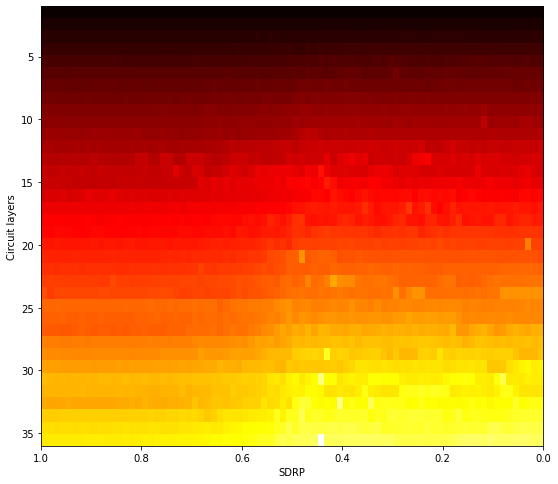

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("SDRP")
plt.ylabel("Circuit layers")

left = 1
right = 0
bottom = 36
top = 1
extent = [left, right, bottom, top]

h = qrack_time_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=(2 * len(h) / (36 * len(h[0]))))

fig.savefig('heat_map_time.png', dpi=100)

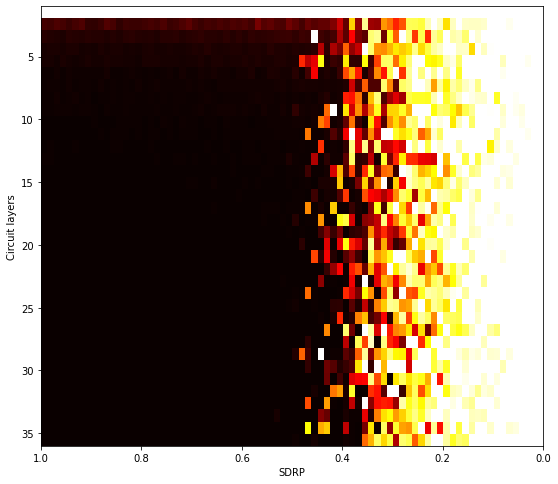

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("SDRP")
plt.ylabel("Circuit layers")

left = 1
right = 0
bottom = 36
top = 1
extent = [left, right, bottom, top]

h = qrack_fidelity_results[36]

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=(2 * len(h) / (36 * len(h[0]))))

fig.savefig('heat_map_fidelity.png', dpi=100)

In [8]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#41~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 31 16:00:14 UTC 2
Linux-5.19.0-40-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-40-generic', version='#41~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 31 16:00:14 UTC 2', machine='x86_64')
Linux
x86_64


In [9]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [10]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'